In [1]:
import torch
from network import NAF
from sound_loader import sound_samples
import utils.irutilities as irutil
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt
import math

path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)

samplerate = 48000

s = 0
m = 32
sample = ir[s,m,:]
src = posSrc[s]
mic = posMic[m]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Loading data...')
dataset = sound_samples(num_samples=20)
# Load NAF with selected configuration
net = NAF(input_dim = 288, min_xy=np.array([-1, -1]), max_xy=np.array([1, 1])).to(device)
state_dict = torch.load('saved/net_20230922_003700_loss_0.0008434.pth')
net.load_state_dict(state_dict)
net.eval()


Loading IRs ...
Loading data...


NAF(
  (block1): Sequential(
    (0): Linear(in_features=416, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.1)
  )
  (tail1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
    (8): Linear(in_features=512, ou

In [ ]:
plt.figure()
plt.imshow(dataset.phases[0,1] / (np.pi * 180))
plt.colorbar()
plt.show()

In [3]:
n_fft = 512
hop = n_fft // 4
data = np.abs(librosa.stft(sample, n_fft=512, hop_length=hop))
phase = np.angle(librosa.stft(sample, n_fft=512, hop_length=hop))
phase = np.unwrap(phase)/180
print(np.max(phase), np.min(phase))
print(np.max(data), np.min(data))

# Reconstruct the audio signal for visualization (optional)
result = librosa.istft(data * np.exp(1j * phase), hop_length=hop)

# Create a figure with two subplots
plt.figure(figsize=(10,10))# Calculate the magnitude spectrogram and phase
plt.show()


2.853763361056433 -1.788534584560162
37.72038977849114 1.1340503426882087e-05


<Figure size 1000x1000 with 0 Axes>

In [4]:
# Ground truth
spectrogram = np.abs(librosa.stft(sample, n_fft=n_fft, hop_length=hop))
gt_s = librosa.amplitude_to_db(spectrogram, ref=np.max)

phase = np.angle(librosa.stft(sample, n_fft=n_fft, hop_length=hop))
gt_p = np.unwrap(phase)

# inference
src = torch.tensor(posSrc[s]).unsqueeze(1).to(device)
mic = torch.tensor(posMic[m]).unsqueeze(1).to(device)
out = net.spectrogram_at(src, mic).cpu()
out_s = (out[:,:,0] * 40) - 40
print(np.min(out_s.numpy()), np.max(out_s.numpy()))
out_p = out[:,:,1]
print(np.min(out_p.numpy()), np.max(out_p.numpy()))

-80.46794 -3.2847672
-0.85789335 0.75010675


(257, 257)
torch.Size([257, 257])


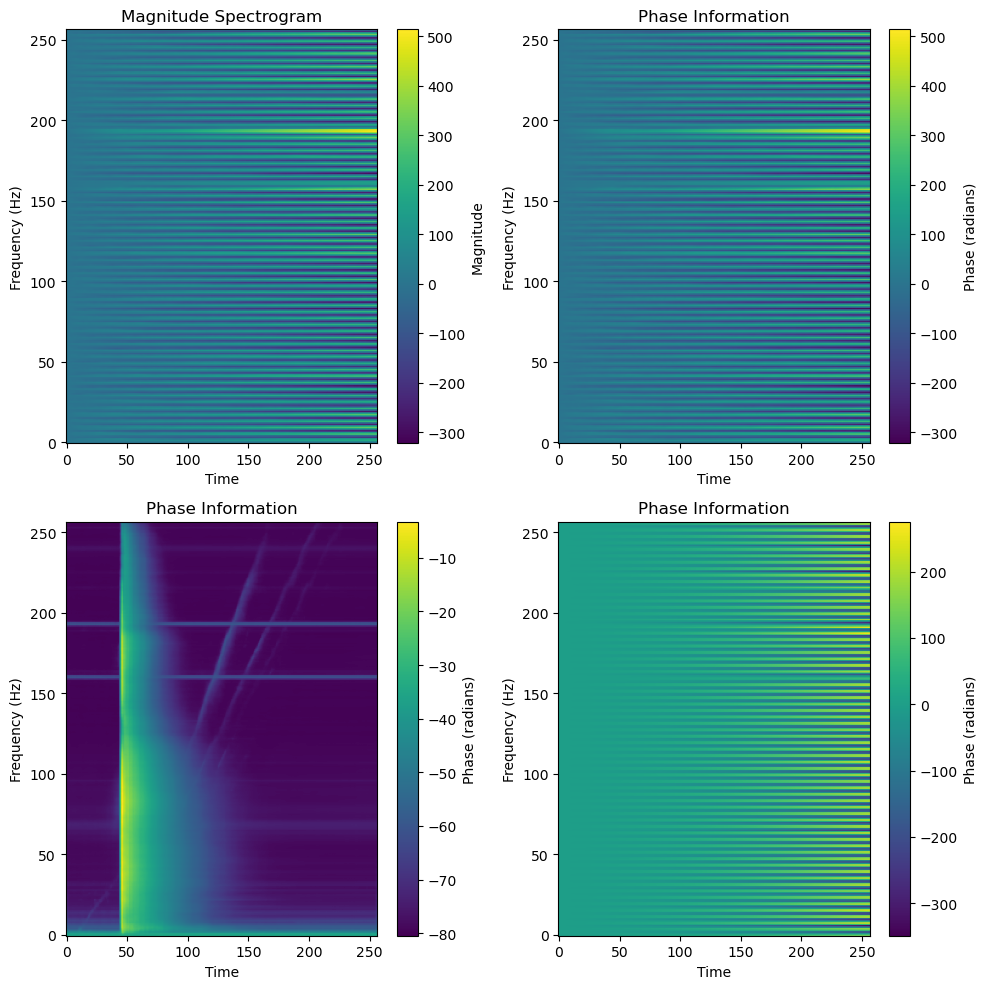

In [6]:
plt.figure(figsize=(10,10))

# Plot the magnitude spectrogram on the left
plt.subplot(221)
plt.imshow(gt_p, cmap='viridis', aspect='auto')
plt.colorbar(label='Magnitude')
plt.title("Magnitude Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

# Plot the phase information on the right
temp = gt_p
#temp = np.diff(temp, axis=0)
#temp = np.cumsum(temp, axis=0) * 180
print(temp.shape)

temp2 = out_p * 180
#temp2 = np.cumsum(np.concatenate((temp2, temp2[-1].reshape(1,-1))), axis=1)
#temp2 = np.cumsum(temp2, axis=1) * np.pi
#print(temp2.shape)
#temp2 = 2 / math.pi * np.arcsin(temp2)
#temp2 = (1/3) * np.arctanh( temp2) * 180

plt.subplot(222)
plt.imshow(temp, cmap='viridis', aspect='auto')
plt.colorbar(label='Phase (radians)')
plt.title("Phase Information")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

plt.subplot(223)
#out_s[out_s > -15] /= 2 
plt.imshow(out_s, cmap='viridis', aspect='auto')
plt.colorbar(label='Phase (radians)')
plt.title("Phase Information")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

plt.subplot(224)
plt.imshow(temp2, cmap='viridis', aspect='auto')
plt.colorbar(label='Phase (radians)')
plt.title("Phase Information")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.gca().invert_yaxis()

# Add space between the subplots
plt.tight_layout()

# Display the plot
plt.show()


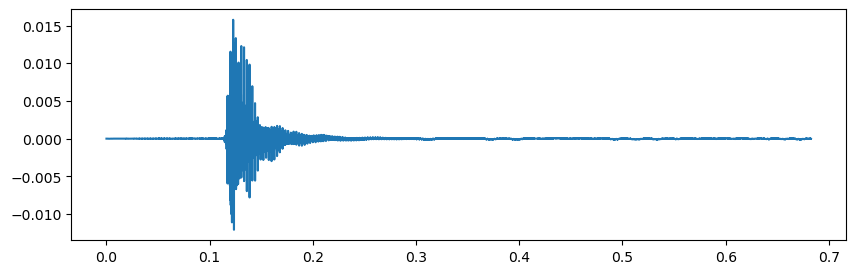

In [7]:
audio = librosa.istft(librosa.db_to_amplitude(out_s.numpy()) * np.exp(1j * temp2.numpy()), hop_length=512//4)
t = np.arange(audio.shape[0]) / samplerate
plt.figure(figsize=(10, 3))
plt.plot(t, audio)
plt.show()

In [ ]:
from matplotlib import rcParams

# Set the font family
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Source Sans Pro']

colors = {
    'white': (0xFE / 255, 0xFE / 255, 0xFE / 255),  # FEFEFE in RGB
    'green': (0x9F / 255, 0xF2 / 255, 0x4B / 255),  # 9FF24B in RGB
    'bg': (0x0F / 255, 0x1D / 255, 0x26 / 255),    # 0F1D26 in RGB
    'blue': (0x3D / 255, 0x8B / 255, 0xF2 / 255),  # 3D8BF2 in RGB
    'red': (0xF2 / 255, 0x13 / 255, 0x65 / 255),   # F21365 in RGB
    'grey': (0x6C / 255, 0x73 / 255, 0x7A / 255)   # 6C737A in RGB
}

# Plot audio and fft
print(out_s, temp2)
audio = librosa.istft(librosa.db_to_amplitude(out_s.numpy()) * np.exp(1j * temp2.numpy()), hop_length=512)

fft_result_sample = np.fft.fft(sample)
freq_sample = np.fft.fftfreq(len(sample), 1.0 / samplerate)
half_n = len(sample) // 2

custom = librosa.istft(librosa.db_to_amplitude(out_s.numpy()) * np.exp(1j * temp2.numpy()), hop_length=512)

ratio = np.max(custom) / np.max(audio)

# Plots
t = np.arange(sample.shape[0]) / samplerate

def causal(arr):
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array.")
    
    if arr.size == 0:
        return arr  # Return the empty array if there are no values.

    # Find the index of the highest value
    max_index = np.argmax(arr)

    # Set all values before the highest value to 0
    arr[:max_index] = 0

    return arr

#audio[audio != 0] *= ratio
#audio = causal(audio)

print('MSE:' ,np.mean((custom-audio)**2))
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
plt.subplot(2, 1, 1)  # Create a subplot for the time domain waveform of 'sample'
#plt.plot(t, sample, label='gt')
plt.plot(t, custom, label='Original Sample', color=colors['blue'])
#plt.plot(t, audio, label='Generated Sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.2)
plt.legend()

plt.subplot(2, 1, 2)  # Create a subplot for the time domain waveform of 'sample'
#plt.plot(t, sample, label='gt')
#plt.plot(t, custom, label='Original Sample')
plt.plot(t, audio, label='Generated Sample', color=colors['red'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.2)


#plt.subplot(2, 1, 2)  # Create a subplot for the frequency domain plot of 'sample'
#plt.plot(freq_sample[:half_n], np.abs(fft_result_sample[:half_n]), label='Sample')
#plt.xlabel('Frequency (Hz)')
#plt.ylabel('Magnitude')
#plt.gca().spines['top'].set_visible(True)
#plt.gca().spines['right'].set_visible(True)
#plt.gca().spines['left'].set_visible(True)
#plt.gca().spines['bottom'].set_visible(True)
#plt.grid(True, linestyle='-', linewidth=0.5, color='black', alpha=0.2)

# Plot 'result' on the same time domain and frequency domain plots
#t_result = np.arange(result.shape[0]) / samplerate

#plt.subplot(2, 1, 1)  # Reuse the top subplot for 'result'
#plt.plot(t_result, result,1.5, label='Result')

#plt.subplot(2, 1, 2)  # Reuse the bottom subplot for 'result'
#fft_result_result = np.fft.fft(result)
#plt.plot(freq_sample[:half_n], np.abs(fft_result_result[:half_n]), label='Result')

# Add legends to distinguish 'sample' and 'result'
plt.legend()
#plt.savefig('amplitude_wrong_causal.png', dpi=300, bbox_inches='tight')

# Save the figure with both plots
plt.tight_layout()
#plt.savefig('ir_amplitude_and_fft_one_side.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import torch
import time

from network import NAF
from sound_loader import sound_samples

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=20)

src = torch.tensor(dataset.posSrc[s, :]).unsqueeze(1).to(device)
mic = torch.tensor(dataset.posMic[m, :]).unsqueeze(1).to(device)

# Load NAF with selected configuration
net = NAF(input_dim = 288, min_xy=dataset.min_pos[:2], max_xy=dataset.max_pos[:2]).to(device)
state_dict = torch.load('saved/net_20230908_081216_loss_0.0013.pth')
net.load_state_dict(state_dict)
net.eval()

start_time = time.time()
out = net.spectrogram_at(src, mic)
exec_time = time.time() - start_time
print(exec_time)
out = (out * dataset.std) + dataset.mean

In [ ]:
phases = np.load('mesh_rir/S32-M441_npy/phases.npy')
print(phases.shape)
phase = phases[0,0,:]

plt.figure(figsize=(10,10))
plt.imshow(phase, aspect='auto')
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sound_loader import sound_samples

print('Loading dataset. It might take a while ...')
dataset = sound_samples(num_samples=20)

# Example spectrograms (replace with your own data)
spectrogram1 = np.random.rand(128, 128)  # Replace with your spectrogram data
spectrogram2 = np.random.rand(128, 128)  # Replace with your spectrogram data

# Combine multiple spectrograms into one if needed


# Step 1: Compute histogram of values
hist, bins = np.histogram(dataset.phases / 180, bins=100)  # You can adjust the number of bins
print(np.min(hist), np.max(hist))
# Step 2: Normalize histogram to create a probability distribution
#hist = np.clip(hist, 0, 8)
hist_normalized = hist / float(np.sum(hist))



print(hist, bins)

# Step 3: Compute inverse probability
inverse_probability = 1.0 / hist_normalized

# Plot the histogram
plt.figure(figsize=(12, 5))
plt.subplot(2, 2, 1)
plt.hist(dataset.phases.flatten(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

plt.figure(figsize=(12, 5))
plt.subplot(2, 2, 3)
plt.hist(hist, bins=100, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

# Plot the inverse probability distribution
plt.subplot(2, 2, 2)
plt.plot(bins[:-1], inverse_probability, color='red')
plt.xlabel('Value')
plt.ylabel('Inverse Probability')
plt.title('Inverse Probability Distribution')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or load your data as a NumPy array (replace this with your own data)
data = (dataset.spectrograms - dataset.mean ) / dataset.std

# Perform histogram equalization directly
hist, bins = np.histogram(data, bins=10, density=True)
print(np.min(hist), np.max(hist))
hist = np.clip(hist, 0, 0.4)
print(np.min(hist), np.max(hist))
hist = hist / float(np.sum(hist))
spectros_probs = 1.0 / hist
mean = np.mean(hist)
weights = np.ones_like(hist) - mean + hist
print(hist)
print(mean)
print(spectros_probs)


# Plot the original and equalized histograms
plt.figure(figsize=(12, 6))

plt.subplot(221)
plt.hist(data.flatten(), bins=10, density=True, color='r', alpha=0.5)
plt.title('Original Histogram')

plt.subplot(222)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), color='r', alpha=0.5)

plt.subplot(223)
plt.bar(bins[:-1], weights, width=(bins[1]-bins[0]), color='r', alpha=0.5)
plt.title('Equalized Histogram')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate or load your data as a NumPy array (replace this with your own data)
data = dataset.phases / 180

# Perform histogram equalization directly
hist, bins = np.histogram(data, bins=10, density=True)
print(np.min(hist), np.max(hist))
#hist = np.clip(hist, 0, 0.02)
print(np.min(hist), np.max(hist))
hist = hist / float(np.sum(hist))
spectros_probs = 1.0 / hist
mean = np.mean(hist)
weights = np.ones_like(hist) - mean + hist
print(hist)
print(mean)
print(spectros_probs)


# Plot the original and equalized histograms
plt.figure(figsize=(12, 6))

plt.subplot(221)
plt.hist(data.flatten(), bins=10, density=True, color='r', alpha=0.5)
plt.title('Original Histogram')

plt.subplot(222)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]), color='r', alpha=0.5)

plt.subplot(223)
plt.bar(bins[:-1], weights, width=(bins[1]-bins[0]), color='r', alpha=0.5)
plt.title('Equalized Histogram')

plt.show()
